# Code Interpreting with GPT-4o
This example uses the E2B's [Code Interpreter](https://github.com/e2b-dev/code-interpreter) as a tool for GPT-4o. We ask GPT-4o to show a chart which means GPT will generate Python code that will get sent to E2B, we display the chart and then ask GPT-4o to reason about the generated chart and create a new chart.

In [57]:
%pip install openai e2b_code_interpreter

Note: you may need to restart the kernel to use updated packages.


In [58]:
# Get your API keys or save them to .env file.
import os
from dotenv import load_dotenv
load_dotenv()

# TODO: Get your OpenAI API key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# TODO: Get your E2B API key from https://e2b.dev/docs
E2B_API_KEY = os.getenv("E2B_API_KEY")


SYSTEM_PROMPT = """
## your job & context
you are a python data scientist. you are given tasks to complete and you run python code to solve them.
You DO NOT MAKE SYNTAX MISTAKES OR FORGET ANY IMPORTS
- the python code runs in jupyter notebook.
- every time you call `execute_python` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
- you can run any python code you want, everything is running in a secure sandbox environment.
"""

tools = [
    {
        "type": "function",
        "function": {
          "name": "execute_python",
          "description": "Execute python code in a Jupyter notebook cell and returns any result, stdout, stderr, display_data, and error.",
          "parameters": {
              "type": "object",
              "properties": {
                  "code": {
                      "type": "string",
                      "description": "The python code to execute in a single cell."
                  }
              },
              "required": ["code"]
          }
        },
    }
]

In [59]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  exec = e2b_code_interpreter.notebook.exec_cell(
    code,
    on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
    on_stdout=lambda stdout: print("[Code Interpreter]", stdout),
    # You can also stream code execution results
    # on_result=...
  )

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec.results

In [60]:
from openai import OpenAI

client = OpenAI(api_key=OPENAI_API_KEY)

def chat(e2b_code_interpreter, user_message, base64_image = None, ):
  print(f"\n{'='*50}\nUser Message: {user_message}\n{'='*50}")

  messages = [
      {
          "role": "system",
          "content": SYSTEM_PROMPT,
      },
  ]

  if base64_image is not None:
    messages.append(
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": user_message,
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
              }
            }
          ]
        }
    )
  else:
    messages.append(
        {"role": "user", "content": user_message},
    )

  response = client.chat.completions.create(
    model="gpt-4o",
    messages=messages,
    tools=tools,
    tool_choice="auto"
  )
  for choice in response.choices:
    if choice.message.tool_calls and len(choice.message.tool_calls) > 0:
      for tool_call in choice.message.tool_calls:
        if tool_call.function.name == "execute_python":
          if "code" in tool_call.function.arguments:
            code = tool_call.function.arguments["code"]
          else:
            code = tool_call.function.arguments
          print("CODE TO RUN")
          print(code)
          code_interpreter_results = code_interpret(e2b_code_interpreter, code)
          return code_interpreter_results
    else:
      print("Answer:", choice.message.content)




User Message: Plot a chart visualizing the height distribution of men based on the data you know
CODE TO RUN
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Generate synthetic data
mean_height = 175  # mean height in cm
std_dev_height = 10  # standard deviation in cm
num_samples = 1000  # number of samples

heights = np.random.normal(mean_height, std_dev_height, num_samples)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(heights, bins=30, edgecolor='black')
plt.title('Height Distribution of Men')
plt.xlabel('Height (cm)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Running code interpreter...
{'text/plain': '<Figure size 1000x600 with 1 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAAA1IAAAIjCAYAAAAJLyrXAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/H5lhTAAAACXBIWXMAAA9hAAAPYQGoP6dpAABPq0lEQVR4nO3deXhTZd7/8U/Spm0KlKWFlkrLvqO4ATIgiyCgwLD5UwRmEFFHB1Q2HXEDVIZFwSoiDD6yjYLL

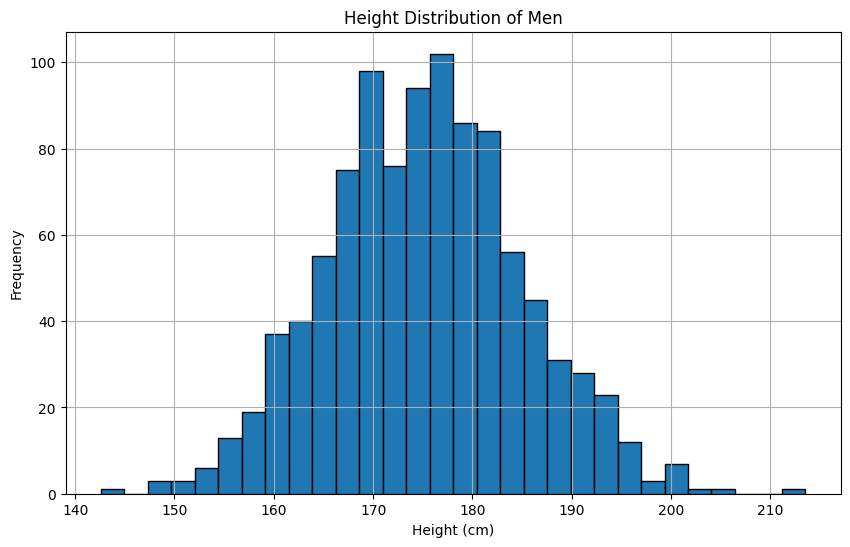

In [62]:
from e2b_code_interpreter import CodeInterpreter
code_interpreter = CodeInterpreter(api_key=E2B_API_KEY)

# 1. Ask GPT-4o to generate chart
code_interpreter_results = chat(
  code_interpreter,
  "Plot a chart visualizing the height distribution of men based on the data you know",
)
print(code_interpreter_results)
plot1 = code_interpreter_results[0]


print(plot1.raw)
plot1


User Message: Based on what you see, what's name of this distribution? Show me the distribution function
CODE TO RUN
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
mu = 70  # mean
sigma = 3  # standard deviation

# Generate data
x = np.linspace(60, 80, 1000)
y = norm.pdf(x, mu, sigma)

# Plot
plt.plot(x, y, label=f'N({mu}, {sigma}^2)')
plt.title('Normal Distribution')
plt.xlabel('Height (inches)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()
Running code interpreter...
{'text/plain': '<Figure size 640x480 with 1 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAAAkAAAAHHCAYAAABXx+fLAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/H5lhTAAAACXBIWXMAAA9hAAAPYQGoP6dpAAB4SElEQVR4nO3deVxU1fsH8M8My7CD7IsI4o4i4BpqLoXikoqVmVkupbZIWZQVLWrbz2wxyxbTcitN06+apZGIWamkAuK+y6Kyy74PM/f3BzI5ssgyw53l8369fBV3zpz7PNxBHs8591yJIAgCiIiIiIyIVOwAiIiIiNoaCyAiIiIyOiyAiIiIyOiwACIiIiKjwwKIiIiIjA4LICIiIjI6LICIiIjI6LAAIiIi

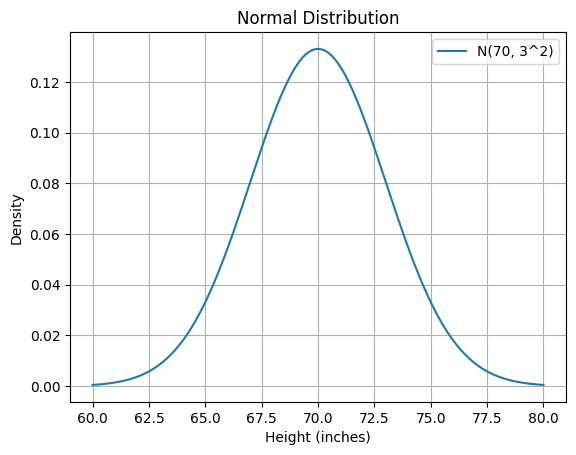

In [ ]:
# 2. Feed the image back the chart to GPT-4o and ask question about the image
image = plot1.png
code_interpreter_results = chat(
  code_interpreter,
  "Based on what you see, what's name of this distribution? Show me the distribution function",
  image,
)

code_interpreter.close()

print(code_interpreter_results)
plot2 = code_interpreter_results[0]
print(plot2.raw)
plot2